In [1]:
from tensorflow.keras import layers
from IPython import display

import glob
import imageio
import os
import PIL
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [7]:
train_images

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE= 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256) # 배치사이즈로 None이 주어진다.

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape==(None, 28, 28, 1)

    return model

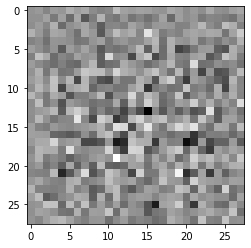

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00045988]], shape=(1, 1), dtype=float32)


In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real_output, fake_output):
    """
    
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
@tf.function
def train_step(images):
    """
    위에서 정의한 손실함수를 바탕으로
    Iteration(=step) 마다 가중치를 갱신합니다.

    Args:
        images: 훈련 데이터셋에 있는 실제 이미지입니다.
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def generate_and_save_images(model, epoch, test_input):
    """
    모델이 이미지를 생성한 후 저장하는 함수입니다.
    
    Args:
        model: 이미지를 생성할 모델입니다.
        epoch: 진행 중인 Epoch 숫자입니다.
        test_input: model에 입력되는 데이터입니다.
    """

    # training=False 이면 모든 층이 추론(inference)모드로 진행됩니다.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [25]:
def train(dataset, epochs):
    """
    학습 중 실행할 동작을 함수로 정의합니다.
    
    Args:
        dataset: (훈련) 데이터셋입니다.
        epochs: 최종 학습 Epoch 입니다.
    """
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 이미지를 생성한 뒤 저장합니다.(추후에 만들 GIF를 위함입니다.)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 15 에포크가 지날 때마다 모델을 Checkpoint에 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        # Epoch 마다 소요 시간을 출력합니다.
        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')

    # 마지막 에포크가 끝난 후 이미지를 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

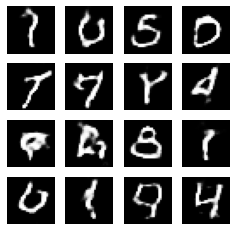

CPU times: user 2min 27s, sys: 33.6 s, total: 3min 1s
Wall time: 11min 41s


In [26]:
%%time
train(train_dataset, EPOCHS)

In [27]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
    
        image = imageio.imread(filename)
        writer.append_data(image)
    
    image = imageio.imread(filename)
    writer.append_data(image)

In [28]:
import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [29]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>